<span id="hello-world" />

# Hola mundo



<details>
  <summary><b>Versiones del paquete</b></summary>

  El código de esta página se ha desarrollado teniendo en cuenta los siguientes requisitos.
  Recomendamos utilizar estas versiones o versiones más recientes.

  ```
  qiskit[all]~=2.1.1
  qiskit-ibm-runtime~=0.40.1
  ```
</details>



Este ejemplo consta de dos partes. Primero crearás un programa cuántico sencillo y lo ejecutarás en una unidad de procesamiento cuántico (QPU).  Dado que la investigación cuántica real requiere programas mucho más robustos, en la segunda sección ([Escala a un gran número de qubits](#scale-to-large-numbers-of-qubits) ), escalarás el programa simple hasta el nivel de utilidad.



<span id="install-and-authenticate" />

## Instalar y autentificar

1.  Si aún no has instalado Qiskit, encontrarás las instrucciones en la guía de [inicio rápido](/docs/guides/quick-start).

    *   Instale Qiskit Runtime para ejecutar trabajos en hardware cuántico:

        ```bash
        pip install qiskit-ibm-runtime
        ```

    *   Configure un entorno para ejecutar cuadernos Jupyter localmente:

        ```bash
        pip install jupyter
        ```

2.  Configure su autenticación para acceder al hardware cuántico a través del [Open Plan](/docs/guides/plans-overview#open-plan) gratuito.

    (Si te enviaron por correo electrónico una invitación para unirte a una cuenta, sigue en su lugar los [pasos para usuarios invitados](/docs/guides/cloud-setup-invited) )

    *   Vaya a [IBM Quantum Platform](/) para iniciar sesión o crear una cuenta.

    *   Genere su clave API (también llamada *token API* ) en el [panel de control](/) y, a continuación, cópiela en una ubicación segura.

    *   Vaya a la página [Instancias](/instances) y busque la instancia que desea utilizar. Pase el ratón por encima de su CRN y haga clic para copiarlo.

    *   Guarda tus credenciales localmente con este código:

        ```python
        from qiskit_ibm_runtime import QiskitRuntimeService

        QiskitRuntimeService.save_account(
        token="<your-api-key>", # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
        instance="<CRN>", # Optional
        )
        ```

3.  Ahora puede utilizar este código Python cada vez que desee autenticarse en el servicio Qiskit Runtime :
    ```python
        from qiskit_ibm_runtime import QiskitRuntimeService

        # Run every time you need the service
        service = QiskitRuntimeService()
    ```

<Admonition type="info" title="¿No utiliza un entorno de confianza Python?">
  Si utiliza un ordenador público u otro entorno no seguro, siga las [instrucciones de autenticación manual](/docs/guides/cloud-setup-untrusted) para mantener a salvo sus credenciales de autenticación.
</Admonition>



<span id="create-and-run-a-simple-quantum-program" />

## Crear y ejecutar un programa cuántico simple



Los cuatro pasos para escribir un programa cuántico utilizando patrones Qiskit son:

1.  Mapear el problema a un formato cuántico-nativo.

2.  Optimice los circuitos y los operadores.

3.  Ejecutar utilizando una función primitiva cuántica.

4.  Analice los resultados.

<span id="step-1-map-the-problem-to-a-quantum-native-format" />

### Paso 1. Pasar el problema a un formato cuántico nativo

En un programa cuántico, *los circuitos cuánticos* son el formato nativo en el que representar las instrucciones cuánticas, y *los operadores* representan los observables que deben medirse. Al crear un circuito, normalmente se crea un nuevo objeto [`QuantumCircuit`](/docs/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) y luego le añadirá instrucciones en secuencia.



La siguiente celda de código crea un circuito que produce un *estado de Bell,* que es un estado en el que dos qubits están totalmente entrelazados entre sí.

<Admonition type="note" title="Nota: ordenación de bits">
  El SDK de Qiskit utiliza la numeración de bits LSb 0 donde el dígito $n^{th}$ tiene valor $1 \ll n$ o $2^n$. Para más detalles, consulta el tema [Ordenación de bits en el SDK de](/docs/guides/bit-ordering) Qiskit.
</Admonition>



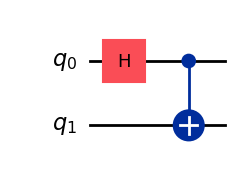

In [5]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl").
# These guides are written by using Jupyter notebooks, which
# display the output of the last line of each cell.
# If you're running this in a script, use `print(qc.draw())` to
# print a text drawing.
qc.draw("mpl")

Consulte [`QuantumCircuit`](/docs/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) en la documentación para conocer todas las operaciones disponibles.



Al crear circuitos cuánticos, también debe considerar qué tipo de datos desea que se devuelvan tras la ejecución. Qiskit proporciona dos formas de devolver datos: puedes obtener una distribución de probabilidad para un conjunto de qubits que elijas medir, o puedes obtener el valor de la expectativa de un observable. Prepara tu carga de trabajo para medir tu circuito de una de estas dos formas con las [primitivas de Qiskit](/docs/guides/get-started-with-primitives) (explicadas en detalle en [el Paso 3](#step-3-execute-using-the-quantum-primitives) ).

Este ejemplo mide valores de expectativa utilizando el submódulo `qiskit.quantum_info` , que se especifica utilizando operadores (objetos matemáticos utilizados para representar una acción o proceso que cambia un estado cuántico). La siguiente celda de código crea seis operadores Pauli de dos qubits: `IZ`, `IX`, `ZI`, `XI`, `ZZ`, y `XX`.



In [6]:
# Set up six different observables.

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

<Admonition type="note" title="Notación de operadores">
  Aquí, algo como el operador `ZZ` es una abreviatura para el producto tensorial $Z\otimes Z$, que significa medir Z en el qubit 1 y Z en el qubit 0 juntos, y obtener información sobre la correlación entre el qubit 1 y el qubit 0. Los valores esperados de este tipo también suelen escribirse como $\langle Z_1 Z_0 \rangle$.

  Si el estado está entrelazado, entonces la medida de $\langle Z_1 Z_0 \rangle$ debería ser diferente de la medida de $\langle I_1 \otimes Z_0 \rangle \langle Z_1 \otimes I_0 \rangle$. Para el estado entrelazado específico creado por nuestro circuito descrito anteriormente, la medida de $\langle Z_1 Z_0 \rangle$ debería ser 1 y la medida de $\langle I_1 \otimes Z_0 \rangle \langle Z_1 \otimes I_0 \rangle$ debería ser cero.
</Admonition>



<span id="optimize" />

<span id="step-2-optimize-the-circuits-and-operators" />

### Paso 2. Optimizar los circuitos y los operadores

Al ejecutar circuitos en un dispositivo, es importante optimizar el conjunto de instrucciones que contiene el circuito y minimizar la profundidad total (aproximadamente el número de instrucciones) del circuito. De este modo, se obtienen los mejores resultados posibles al reducir los efectos del error y el ruido. Además, las instrucciones del circuito deben ajustarse a la [arquitectura del conjunto de instrucciones (ISA)](/docs/guides/transpile#instruction-set-architecture) de un dispositivo backend y deben tener en cuenta las puertas base y la conectividad qubit del dispositivo.

El siguiente código instancia un dispositivo real al que enviar un trabajo y transforma el circuito y los observables para que coincidan con el ISA de ese backend. Requiere que ya hayas [guardado tus credenciales](/docs/guides/cloud-setup)



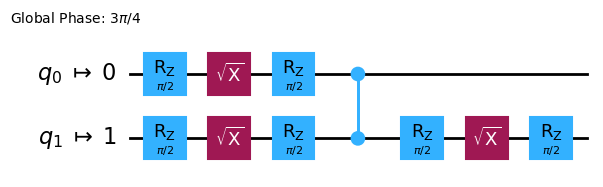

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", idle_wires=False)

<span id="step-3-execute-using-the-quantum-primitives" />

### Paso 3. Ejecutar utilizando las primitivas cuánticas

Los ordenadores cuánticos pueden producir resultados aleatorios, por lo que se suele recoger una muestra de las salidas ejecutando el circuito muchas veces. Puede estimar el valor del observable utilizando la clase `Estimator` . `Estimator` es una de las dos [primitivas](/docs/guides/get-started-with-primitives); la otra es `Sampler`, que puede utilizarse para obtener datos de un ordenador cuántico.  Estos objetos poseen una `run()` método que ejecuta la selección de circuitos, observables y parámetros (si corresponde), utilizando un [bloque unificado primitivo ( PUB ).](/docs/guides/primitives#sampler)



In [8]:
# Construct the Estimator instance.

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d50e2rsgk3fc73avtsh0


Después de enviar un trabajo, puede esperar hasta que el trabajo se complete dentro de su instancia actual de python, o utilizar `job_id` para recuperar los datos en otro momento.  (Para más detalles, consulte la [sección sobre recuperación de trabajos](/docs/guides/monitor-job#retrieve-job-results-at-a-later-time) )

Una vez completado el trabajo, examine su salida a través del atributo `result()` del trabajo.



In [10]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

<Admonition type="note" title="Alternativa: ejecutar el ejemplo con un simulador">
  Cuando ejecutas tu programa cuántico en un dispositivo real, tu carga de trabajo debe esperar en una cola antes de ejecutarse. Para ahorrar tiempo, puede utilizar en su lugar el siguiente código para ejecutar esta pequeña carga de trabajo en la aplicación [`fake_provider`](../api/qiskit-ibm-runtime/fake-provider) con el modo de prueba local Qiskit Runtime. Tenga en cuenta que esto sólo es posible para un circuito pequeño. Cuando aumentes la escala en la siguiente sección, tendrás que utilizar un dispositivo real.

  ```python

  # Use the following code instead if you want to run on a simulator:

  from qiskit_ibm_runtime.fake_provider import FakeFez
  backend = FakeFez()
  estimator = Estimator(backend)

  # Convert to an ISA circuit and layout-mapped observables.

  pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
  isa_circuit = pm.run(qc)
  mapped_observables = [
      observable.apply_layout(isa_circuit.layout) for observable in observables
  ]

  job = estimator.run([(isa_circuit, mapped_observables)])
  result = job.result()

  # This is the result of the entire submission.  You submitted one Pub,
  # so this contains one inner result (and some metadata of its own).

  job_result = job.result()

  # This is the result from our single pub, which had five observables,
  # so contains information on all five.

  pub_result = job.result()[0]
  ```
</Admonition>



<span id="step-4-analyze-the-results" />

### Paso 4. Analizar los resultados

En la etapa de análisis es donde se suelen postprocesar los resultados utilizando, por ejemplo, la mitigación de errores de medición o la extrapolación de ruido cero (ZNE). Puede introducir estos resultados en otro flujo de trabajo para un análisis más detallado o preparar un gráfico de los valores y datos clave. En general, este paso es específico para su problema.  Para este ejemplo, traza cada uno de los valores de expectativa que se midieron para nuestro circuito.

Los valores esperados y las desviaciones estándar de los observables especificados a Estimator son accesibles a través de los atributos `PubResult.data.evs` y `PubResult.data.stds` del resultado del trabajo. Para obtener los resultados de Sampler, utilice la función `PubResult.data.meas.get_counts()` , que devolverá un `dict` de medidas en forma de cadenas de bits como claves y recuentos como sus valores correspondientes. Para más información, consulte [Introducción a Sampler.](/docs/guides/get-started-with-primitives#get-started-with-sampler)



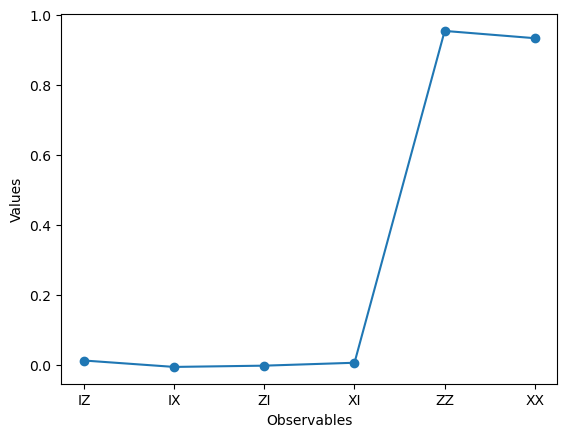

In [11]:
# Plot the result

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

Obsérvese que para los qubits 0 y 1, los valores de las expectativas independientes de X y Z son 0, mientras que las correlaciones (`XX` y `ZZ`) son 1. Este es un sello distintivo del entrelazamiento cuántico.



<span id="scale-to-large-numbers-of-qubits" />

## Escala a un gran número de qubits

En computación cuántica, el trabajo a escala comercial es crucial para avanzar en este campo. Este tipo de trabajo requiere que los cálculos se realicen a una escala mucho mayor, trabajando con circuitos que pueden utilizar más de 100 qubits y más de 1.000 compuertas. Este ejemplo demuestra cómo se puede llevar a cabo un trabajo a escala utilitaria en IBM® QPUs creando y analizando un estado GHZ de 100 qubits.  Utiliza el flujo de trabajo de los patrones Qiskit y termina midiendo el valor de expectativa $\langle Z_0 Z_i \rangle $ para cada qubit.

<span id="step-1-map-the-problem" />

### Paso 1. Mapear el problema

Escribe una función que devuelva un `QuantumCircuit` que prepare un estado $n$ -qubit GHZ (esencialmente un estado Bell extendido), luego usa esa función para preparar un estado GHZ de 100-qubit y recoge los observables a medir.



In [12]:
from qiskit import QuantumCircuit


def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.

    Args:
        n (int): Number of qubits in the n-qubit GHZ state

    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n - 1):
            qc.cx(i, i + 1)
    else:
        raise Exception("n is not a valid input")
    return qc


# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)

A continuación, trace un mapa de los operadores de interés. Este ejemplo utiliza los operadores `ZZ` entre qubits para examinar el comportamiento a medida que se alejan.  Unos valores de expectativas cada vez más imprecisos (corruptos) entre qubits distantes revelarían el nivel de ruido presente.



In [13]:
from qiskit.quantum_info import SparsePauliOp

# ZZII...II, ZIZI...II, ... , ZIII...IZ
operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n - 1)
]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

<span id="step-2-optimize-the-problem-for-execution-on-quantum-hardware" />

### Paso 2. Optimizar el problema para su ejecución en hardware cuántico

El siguiente código transforma el circuito y los observables para que coincidan con el ISA del backend. Requiere que ya hayas [guardado tus credenciales](/docs/guides/cloud-setup)



In [14]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.least_busy(
    simulator=False, operational=True, min_num_qubits=100
)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

<span id="step-3-execute-on-hardware" />

### Paso 3. Ejecutar en hardware

Envíe el trabajo y active la supresión de errores mediante una técnica de reducción de errores denominada [desacoplamiento dinámico.](../api/qiskit-ibm-runtime/options-dynamical-decoupling-options) El nivel de resiliencia especifica cuánta resiliencia construir contra los errores. Los niveles más altos generan resultados más precisos, a costa de tiempos de procesamiento más largos.  Si desea más información sobre las opciones establecidas en el código siguiente, consulte [Configurar la mitigación de errores para Qiskit Runtime](/docs/guides/configure-error-mitigation)



In [15]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

# Create an Estimator object
estimator = Estimator(backend, options=options)

In [16]:
# Submit the circuit to Estimator
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

d50e55deastc73cj5nng


<span id="step-4-post-process-results" />

### Paso 4. Resultados del procesamiento posterior

Una vez finalizado el trabajo, grafique los resultados y observe que $\langle Z_0 Z_i \rangle$ disminuye al aumentar $i$, a pesar de que en una simulación ideal todos los $\langle Z_0 Z_i \rangle$ deberían ser 1.



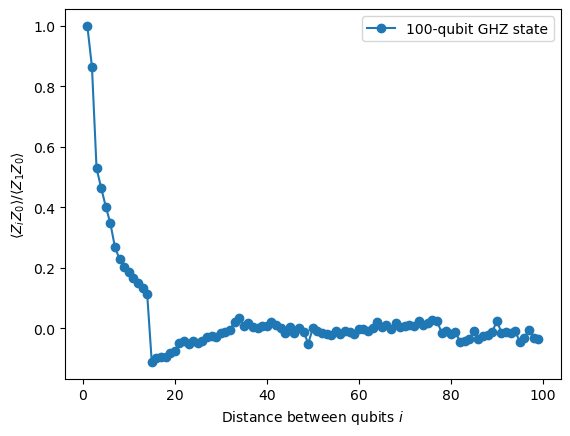

In [17]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

# data
data = list(range(1, len(operators) + 1))  # Distance between the Z operators
result = job.result()[0]
values = result.data.evs  # Expectation value at each Z operator.
values = [
    v / values[0] for v in values
]  # Normalize the expectation values to evaluate how they decay with distance.

# plotting graph
plt.plot(data, values, marker="o", label="100-qubit GHZ state")
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()

El gráfico anterior muestra que, a medida que aumenta la distancia entre qubits, la señal decae debido a la presencia de ruido.



<span id="next-steps" />

## Pasos siguientes

<Admonition type="tip" title="Recomendaciones">
  *   Prueba uno de estos tutoriales:
      *   [Estimación de la energía en estado básico de la cadena de Heisenberg con VQE](/docs/tutorials/spin-chain-vqe)
      *   Resolver problemas de optimización mediante [QAOA](/docs/tutorials/quantum-approximate-optimization-algorithm)
      *   Entrenar modelos [de núcleo cuántico](/docs/tutorials/quantum-kernel-training) para tareas de aprendizaje automático
  *   Encontrarás instrucciones detalladas de instalación en la guía [Instalar Qiskit](/docs/guides/install-qiskit).
  *   Si prefieres no instalar Qiskit localmente, lee sobre las opciones para usar Qiskit en un [entorno de desarrollo online.](/docs/guides/online-lab-environments)
  *   Para guardar las credenciales de varias cuentas o especificar otras opciones de cuenta, consulte las instrucciones detalladas de la guía [Guardar las credenciales de inicio de sesión](/docs/guides/save-credentials#save-your-access-credentials).
</Admonition>



© IBM Corp., 2017-2025